<a href="https://colab.research.google.com/github/16A0/til/blob/master/torchgan-Adversarial_Autoencoder_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 5: Adversarial Autoencoder

**Author** - [Yatin Dandi](https://yatindandi.github.io)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/torchgan/torchgan/blob/master/tutorials/Tutorial%205.%20Adversarial%20Autoencoder.ipynb)

In this tutorial we will explore **Adversarial Autoencoders** (AAE), which use Generative Adversarial Networks to perform variational inference. As explained in [Adversarial Autoencoders (Makhzani et. al.)](https://arxiv.org/pdf/1511.05644), the aggregated posterior distribution of the latent representation of the autoencoder is matched to an arbitrary prior distribution using adversarial training.

The tutorial helps you with the following:

1. General workflow for implementing GAN models with inference networks using **TorchGAN**
2. Implementing custom losses with a nonstandard training loop

This tutorial assumes that your system has **PyTorch** and **TorchGAN** installed properly. If not, the following code block will try to install the **latest tagged version** of TorchGAN. If you need to use some other version head over to the installation instructions on the [official documentation website](https://torchgan.readthedocs.io/en/latest/).

Source of this code is https://github.com/torchgan/torchgan/blob/master/tutorials/Tutorial%205.%20Adversarial%20Autoencoder.ipynb

In [2]:
try:
    import torchgan

    print(f"Existing TorchGAN {torchgan.__version__} installation found")
except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchgan"])
    import torchgan

    print(f"Installed TorchGAN {torchgan.__version__}")

Existing TorchGAN v0.0.4 installation found


## IMPORTS

In [0]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.optim import Adam
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Torchgan Imports
import torchgan.models as models
import torchgan.losses as losses
from torchgan.trainer import Trainer

In [4]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## LOAD THE DATASET

We make the following transforms before feeding the **MNIST Dataset** into the networks

1. The default size of MNIST is $1 \times 28 \times 28$. However, by convention, the default input size in **torchgan.models** is a power of 2 and at least 16. Hence we shall be resizing the images to $1 \times 32 \times 32$.  One can also **zero-pad** the boundary, without any noticeable difference 

2. The output quality of GANs is improved when the images are constrained in the range The images are normalized with a mean and standard deviation of **0.5** , thereby constraining most of the inputs in the range (-1, 1)

Finally the **torchgan.trainer.Trainer** needs a **DataLoader** as input. So we are going to construct a DataLoader for the MNIST Dataset.

In [5]:
dataset = dsets.MNIST(
    root="./mnist",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ]
    ),
    download=True,
)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
loader = data.DataLoader(dataset, batch_size=64, shuffle=True)

## GENERATOR MODEL

The AAE Generator corresponds to the encoder of the autoencoder. It takes as input an image in the form of a torch Tensor of size $batch\ size \times 1 \times 32 \times 32$ and outputs a tuple of  reconstructed images of size $batch\ size \times 1 \times 32 \times 32$ and the encoding of size $batch\ size \times \ encoding \ dims$. The sampling of images is done by feeding the noise through the decoder. Unlike GANs, AAE allows inference of latent encodings from images which can be used for various downstream tasks. The distribution of the sampled encodings from the dataset (the aggregated posterior) is encouraged to match the prior distribution through adversarial training. Here we have implemented the deterministic version of the autoencoder which gives similar results to the variants with gaussian/universal approximator posterior as described in Adversarial Autoencoders (Makhzani et. al.)

 **For encoder**:

1. **Channel Dimension**: $input \ channels \rightarrow d \rightarrow 4d \rightarrow 16d \rightarrow \ encoding \ dims$.
2. **Image size**: $(32 \times 32) \rightarrow (16 \times 16) \rightarrow (4 \times 4) \rightarrow (1 \times 1)$

**For decoder (sampling)**:

1. **Channel Dimension**: $\ encoding \ dims \rightarrow d \rightarrow 4d \rightarrow 16d \rightarrow input \ channels$.
2. **Image size**: $(1 \times 1) \rightarrow (4 \times 4) \rightarrow (16 \times 16) \rightarrow (32 \times 32)$

LeakyReLU is used as the default nonlinearity in both the encoder and the decoder as Relu kills most of the gradients.  One can easily change the nonlinearity of the intermediate and the last layers as per their preference by passing them as parameters during initialization of the Generator object.

In [7]:
class AdversarialAutoencoderGenerator(models.Generator):
    def __init__(
        self,
        encoding_dims,
        input_size,
        input_channels,
        step_channels=16,
        nonlinearity=nn.LeakyReLU(0.2),
    ):
        super(AdversarialAutoencoderGenerator, self).__init__(encoding_dims)
        encoder = [
            nn.Sequential(
                nn.Conv2d(input_channels, step_channels, 5, 2, 2), nonlinearity
            )
        ]
        size = input_size // 2
        channels = step_channels
        while size > 1:
            encoder.append(
                nn.Sequential(
                    nn.Conv2d(channels, channels * 4, 5, 4, 2),
                    nn.BatchNorm2d(channels * 4),
                    nonlinearity,
                )
            )
            channels *= 4
            size = size // 4
        self.encoder = nn.Sequential(*encoder)
        self.encoder_fc = nn.Linear(
            channels, encoding_dims
        )  # Can add a Tanh nonlinearity if training is unstable as noise prior is Gaussian
        self.decoder_fc = nn.Linear(encoding_dims, step_channels)
        decoder = []
        size = 1
        channels = step_channels
        while size < input_size // 2:
            decoder.append(
                nn.Sequential(
                    nn.ConvTranspose2d(channels, channels * 4, 5, 4, 2, 3),
                    nn.BatchNorm2d(channels * 4),
                    nonlinearity,
                )
            )
            channels *= 4
            size *= 4
        decoder.append(nn.ConvTranspose2d(channels, input_channels, 5, 2, 2, 1))
        self.decoder = nn.Sequential(*decoder)

    def sample(self, noise):
        noise = self.decoder_fc(noise)
        noise = noise.view(-1, noise.size(1), 1, 1)
        return self.decoder(noise)

    def forward(self, x):
        if self.training:
            encoding = self.encoder(x)
            encoding = self.encoder_fc(
                encoding.view(
                    -1, encoding.size(1) * encoding.size(2) * encoding.size(3)
                )
            )
            return self.sample(encoding), encoding
        else:
            return self.sample(x)

## DISCRIMINATOR NETWORK

The AAE discriminator is trained to classify an input noise vector as being real(sampled from the prior) or fake (generated by the encoder). It is thus a simple MLP which outputs the logits to be used with the minimax loss.

For reasons same as above we use a **Leaky ReLU** activation. The encoding size is halved successively till it reaches the threshold of 16. The last linear layer subsequently converts this to real output for the logit.

In [0]:
class AdversarialAutoencoderDiscriminator(models.Discriminator):
    def __init__(self, input_dims, nonlinearity=nn.LeakyReLU(0.2)):
        super(AdversarialAutoencoderDiscriminator, self).__init__(input_dims)
        model = [nn.Sequential(nn.Linear(input_dims, input_dims // 2), nonlinearity)]
        size = input_dims // 2
        while size > 16:
            model.append(
                nn.Sequential(
                    nn.Linear(size, size // 2), nn.BatchNorm1d(size // 2), nonlinearity
                )
            )
            size = size // 2
        model.append(nn.Linear(size, 1))
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## LOSS FUNCTIONS

The loss function of the autoencoder consists of two terms:

1. The reconstruction error: Mean squared error between the input image and the reconstruction.
2. The negative log likelihood of the generated noise (encodings) w.r.t to the discriminator.

The loss function of the discriminator consists of the minimax loss with the encodings generated by the encoder as the fake samples and the noise generated by the prior as the real samples.


In [0]:
class AdversarialAutoencoderGeneratorLoss(losses.GeneratorLoss):
    def forward(self, real_inputs, gen_inputs, dgz):
        loss = 0.999 * F.mse_loss(gen_inputs, real_inputs)
        target = torch.ones_like(dgz)
        loss += 0.001 * F.binary_cross_entropy_with_logits(dgz, target)
        return loss

    def train_ops(
        self,
        generator,
        discriminator,
        optimizer_generator,
        real_inputs,
        device,
        batch_size,
        labels=None,
    ):
        recon, encodings = generator(real_inputs)
        optimizer_generator.zero_grad()
        dgz = discriminator(encodings)
        loss = self.forward(real_inputs, recon, dgz)
        loss.backward()
        optimizer_generator.step()
        return loss.item()


class AdversarialAutoencoderDiscriminatorLoss(losses.DiscriminatorLoss):
    def forward(self, dx, dgz):
        target_real = torch.ones_like(dx)
        target_fake = torch.zeros_like(dx)
        loss = 0.5 * F.binary_cross_entropy_with_logits(dx, target_real)
        loss += 0.5 * F.binary_cross_entropy_with_logits(dgz, target_fake)
        return loss

    def train_ops(
        self,
        generator,
        discriminator,
        optimizer_discriminator,
        real_inputs,
        device,
        batch_size,
        labels=None,
    ):
        _, encodings = generator(real_inputs)
        noise = torch.randn(real_inputs.size(0), generator.encoding_dims, device=device)
        optimizer_discriminator.zero_grad()
        dx = discriminator(noise)
        dgz = discriminator(encodings)
        loss = self.forward(dx, dgz)
        loss.backward()
        optimizer_discriminator.step()
        return loss.item()


losses = [
    AdversarialAutoencoderGeneratorLoss(),
    AdversarialAutoencoderDiscriminatorLoss(),
]

## OPTIMIZERS AND HYPERPARAMETERS

The models, their corresponding optimizers and other hyperparameters like the nonlinearities to be used in the intermediate layers are bundled in the form of a dictionary and provided to the trainer for instantiation. The dictionary specifies the models that are to be trained, the optimizers associated with said models and learning rate schedulers, if any


1. "name": The class name for the model. Generally a subclass of the ```torchgan.models.Generator``` or ```torchgan.models.Discriminator```
2. "args": Arguments fed into the class during instantiation, into its constructor 
3. "optimizer": A dictionary containing the following key-value pairs defining the optimizer associated with the model
    * "name" : The class name of the optimizer. Generally an optimizer from the ```torch.optim``` package
    * "args" : Arguments to be fed to the optimizer during its instantiation, into its constructor
    * "var": Variable name for the optimizer. This is an optional argument. If this is not provided, we assign the optimizer the name ```optimizer_{}``` where {} refers to the variable name of the model.
    * "scheduler": Optional scheduler associated with the optimizer. Again this is a dictionary with the following keys
        * "name" : Class name of the scheduler
        * "args" : Arguments to be provided to the scheduler during instantiation, into its constructor

In [0]:
network = {
    "generator": {
        "name": AdversarialAutoencoderGenerator,
        "args": {"encoding_dims": 128, "input_size": 32, "input_channels": 1},
        "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": AdversarialAutoencoderDiscriminator,
        "args": {"input_dims": 128,},
        "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}},
    },
}

## TRAINING THE ADVERSARIAL AUTOENCODER

Next we simply feed the network descriptors and the losses we defined previously into the Trainer. Then we pass the **MNIST DataLoader** to the trainer object and wait for training to complete.

---

Important information for visualizing the performance of the GAN will be printed to the console. The best and recommended way to visualize the training is to use **tensorboardX**. It plots all the data and periodically displays the generated images. It allows us to track failure of the model early.

*NB: Training the models are quite expensive. Hence we will train the models for **10** epochs if a GPU is available, else we will be training for only **5** epochs. We recommend using the **GPU runtime** in Colab. The images will not look even close to realistic in **5** epochs but shall be enough to show that it is learning to generate good quality images. If you have access to powerful GPUs or want to see realistic samples, I would recommend simply increasing the **epochs** variable (to around **200**) in the next code block.*

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 10
else:
    device = torch.device("cpu")
    epochs = 5

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 10


In [12]:
trainer = Trainer(network, losses, sample_size=64, epochs=epochs, device=device)
trainer(loader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 48.228039503097534
generator Mean Gradients : 80.35321447636075
discriminator Mean Gradients : 0.11115619287259801
Mean Running Discriminator Loss : 0.6390083252366926
Mean Running Generator Loss : 0.24570516978245555
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AdversarialAutoencoderGeneratorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AdversarialAutoencoderDiscriminatorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 47.882649421691895
generator Mean Gradients : 45.124600214637205
discriminator Mean Gradients : 0.4680445859427922
Mean Running Discriminator Loss : 0.552115475651679
Mean Running Generator Loss : 0.1960875893246009
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 47.61538743972778
generator Mean Gradients : 31.687310413560233
discriminator Mean Gradients : 0.8486472315905922
Mean Running Discriminator Loss : 0.4537199234435045
Mean Running Generator Loss : 0.17587673513175073
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 47.513742208480835
generator Mean Gradients : 24.452917180312102
discriminator Mean Gradients : 0.9981689335345489
Mean Running Discriminator Loss : 0.3800607760395132
Mean Running Generator Loss : 0.1641974103257759

## VISUALIZING THE SAMPLES

Once training is complete, one can easily visualize the loss curves, gradient flow and sampled images per epoch on either the **TensorboardX** or **Vizdom** backends. For the purposes of this tutorial, we plot some of the sampled images here itself.

*NB: It is highly recommended to view the results on TensorboardX or Vizdom if you are running this tutorial locally*

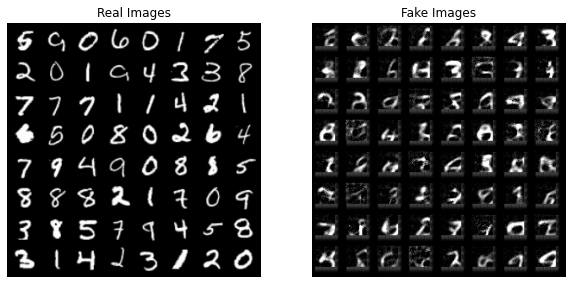

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

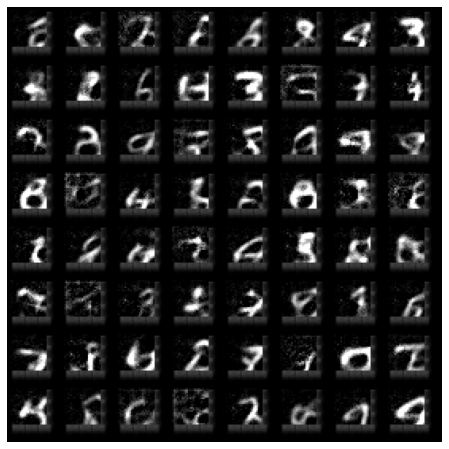

In [14]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))]
    for i in range(1, trainer.epochs + 1)
]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())